In [62]:
import torchvision.transforms.functional as TF, torch.nn.functional as F
from miniai.datasets import *
from datasets import load_dataset

### Load Tiny-ImageNet

In [63]:
xl,yl = 'image','label'
name = "zh-plus/tiny-imagenet"
dsd = load_dataset(name)

In [64]:
@inplace
def transformi(b): 
    b[xl] = [TF.to_tensor(o)-0.0 for o in b[xl]]

bs = 64
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs)

In [65]:
dt = dls.train
xb,yb = next(iter(dt))

In [66]:
xb.shape, yb.shape

(torch.Size([64, 3, 64, 64]), torch.Size([64]))

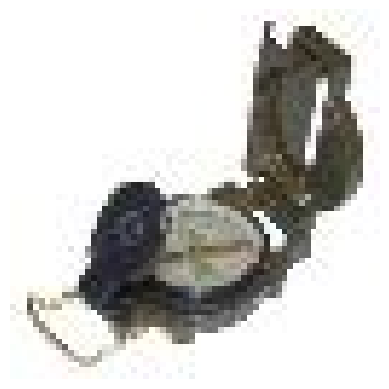

In [67]:
show_image(xb[17]);

### Load CLIP model

In [68]:
from transformers import CLIPModel, CLIPProcessor
import torch
from torch import nn

In [69]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [70]:
inputs = processor(images=xb, return_tensors="pt")
dict(inputs).keys(), inputs["pixel_values"].shape

(dict_keys(['pixel_values']), torch.Size([64, 3, 224, 224]))

In [71]:
with torch.no_grad():
    outputs = model.get_image_features(**inputs)

In [72]:
outputs.shape

torch.Size([64, 512])

### CLIPUNetModel v 1.0.0

We want the 512 dimensional embeddings to end up being (64, nf, 1, 1) for nf in (224, 448, 672, 896).

In [73]:
# Example of the transformation occuring to embeddings in CondUNetModel()
def combined_embs(nf, t, c):
    n_emb = nf*4

    t_emb = timestep_embedding(t, nf)
    mlp_t = nn.Sequential(lin(n_temb, n_emb, norm=nn.BatchNorm1d), lin(n_emb, n_emb))
    t_emb = mlp_t(t_emb)

    mlp_c = nn.Sequential(lin(c.shape[1], n_emb, norm=nn.BatchNorm1d), lin(n_emb, n_emb))
    c_emb = mlp_c(c)
    
    emb = t_emb + c_emb
    linear = nn.Linear(n_emb, nf*2)
    emb2 = linear(F.silu(emb))[:, :, None, None]

    return torch.chunk(emb2, 2, dim=1)

In [74]:
# Updated CondUNetModel to support CLIP image embeddings
class CLIPUNetModel(nn.Module):
    def __init__( self, in_channels=3, out_channels=3, nfs=(224,448,672,896), num_layers=1):
        super().__init__()
        self.conv_in = nn.Conv2d(in_channels, nfs[0], kernel_size=3, padding=1)
        self.n_temb = nf = nfs[0]
        n_emb = nf*4
        self.c_emb_mlp = nn.Sequential(lin(self.c.shape[1], n_emb, norm=nn.BatchNorm1d), lin(n_emb, n_emb))
        self.t_emb_mlp = nn.Sequential(lin(self.n_temb, n_emb, norm=nn.BatchNorm1d), lin(n_emb, n_emb))
        self.downs = nn.ModuleList()
        for i in range(len(nfs)):
            ni = nf
            nf = nfs[i]
            self.downs.append(DownBlock(n_emb, ni, nf, add_down=i!=len(nfs)-1, num_layers=num_layers))
        self.mid_block = EmbResBlock(n_emb, nfs[-1])

        rev_nfs = list(reversed(nfs))
        nf = rev_nfs[0]
        self.ups = nn.ModuleList()
        for i in range(len(nfs)):
            prev_nf = nf
            nf = rev_nfs[i]
            ni = rev_nfs[min(i+1, len(nfs)-1)]
            self.ups.append(UpBlock(n_emb, ni, prev_nf, nf, add_up=i!=len(nfs)-1, num_layers=num_layers+1))
        self.conv_out = pre_conv(nfs[0], out_channels, act=nn.SiLU, norm=nn.BatchNorm2d, bias=False)

    def forward(self, inp):
        x,t,c = inp
        temb = timestep_embedding(t, self.n_temb)
        emb = self.t_emb_mlp(temb) + self.c_emb_mlp(c)
        x = self.conv_in(x)
        saved = [x]
        for block in self.downs: x = block(x, emb)
        saved += [p for o in self.downs for p in o.saved]
        x = self.mid_block(x, emb)
        for block in self.ups: x = block(x, emb, saved)
        return self.conv_out(x)